$$\require{mhchem}$$

# HW1 (due 9/4)

# Catalyst deactivation in a batch reactor [50 pts]

Consider the irreversible, liquid-phase isomerization reaction carried out in a solvent containing dissolved catalyst at 25 C in a batch reactor:
\begin{align*}
\ce{B ->[k_b] C}
\end{align*}
The apparent first-order reaction rate constant $k_b$ decreases with time because of catalyst deterioriation. A chemist friend of yours has studied the catalyst deactivation process and has proposed that it can be modeled with
\begin{align*}
k_b = \frac{k}{1+k_dt}
\end{align*}
in which $k$ is the fresh catalyst rate constant and $k_d$ is the deactivation rate constant.

We can derive the ODE to solve by starting with a mol balance on the entire system:
\begin{align*}
\frac{dN_b}{dt} &=N_b^0 - Vr \\
\frac{dC_b}{dt} &= -k_bC_b=-\frac{kC_b}{1+k_dt} 
\end{align*}
with the initial condition $C_b(t=0)=C_{b0}=5$ M.

## Mol balance solve

Solve the mole balance for $C_B(t)$ assuming $k$=0.6/hr and $k_d$=2/hr for the first two hours. Plot the conversion % for your solution (defined as $1-C_B(t)/C_{B0}$).

Text(0, 0.5, 'conversion %')

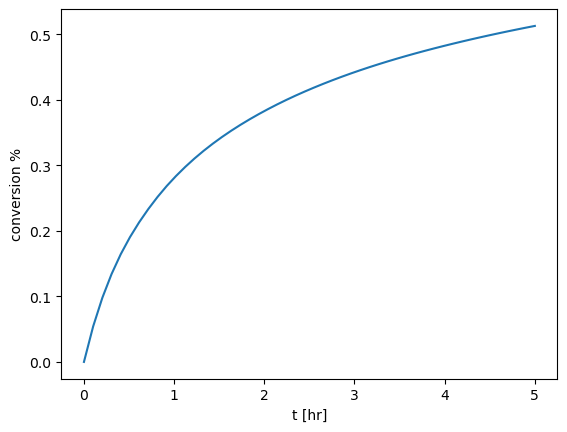

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# define parameters
k = 0.6  # 1/hr
k_d = 2.0  # 1/hr
Cb_0 = 5  # M


# define the ODE
def dCb_dt(t: float, Cb: float) -> float:
    return -(k * Cb) / (1 + k_d * t)


# define time span and eval times
t_span = [0, 5]
t_eval = np.linspace(*t_span, 50)

# integrate ODE
sol = solve_ivp(fun=dCb_dt, t_span=t_span, y0=[Cb_0], t_eval=t_eval)

# get Cb(t)
Cb_t = sol.y[0]

# compute conversion %
conv = 1 - Cb_t / Cb_0

# plot conversion
fig, ax = plt.subplots()
ax.plot(t_eval, conv)
ax.set_xlabel("t [hr]")
ax.set_ylabel(r"conversion %")

## If it takes two hours to reach 50% conversion and the fresh catalyst has a rate constant of 0.6/hr what is the actual $k_d$?

We know that $C_b(t=0)=C_{b0}$, $\frac{C_b(t=2)}{C_{b0}} = 0.5$ and $k = 0.6/hr$. We attempt to solve the ODE analytically to find an expression for $C_b(t)$:
\begin{align*}
\frac{dC_b}{dt} &= -\frac{k C_b}{1+k_d t}  \\
\Rightarrow \ln \frac{C_b(t)}{C_{b0}} &= -\frac{k}{k_d} \ln(k_d t +1) \\
\end{align*}
To solve for $k_d$, we use [`scipy.optimize.fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html):

In [2]:
from scipy.optimize import fsolve

# define parameters
t = 2.0  # h
conv_at_t = 0.5  # C_b(t=2)/C_b0
k = 0.6  # 1/hr

# ODE function to integrate
def dCb_dt(t: float, Cb: float, k_d: float) -> float:
    return -(k * Cb) / (1 + k_d * t)


# Objective to decide how close the solution is for a given k_d
# We want to make this objective equal to 0!
def objective(k_d):

    # Solve the ODE
    sol = solve_ivp(fun=dCb_dt, t_span=[0, 2], y0=[Cb_0], args=(k_d,))

    # Get the final concentration
    Cb = sol.y[0, -1]

    # Return how far the final conversion is from 0.5
    return (1 - (Cb / Cb_0)) - 0.5


k_d_actual = fsolve(func=objective, x0=[2])[0]

print(f"The actual k_d is {k_d_actual:.3f}")

The actual k_d is 0.877


## Using $k_d$ you found from the previous step, use `solve_ivp` events to determine how long it takes to reach 75% conversion in the reactor.

In [3]:
# create new event for conversion = 0.75
def conversionTargetReached(t: float, Cb: np.array, k_d: float) -> float:
    return (1 - (Cb[0] / Cb_0)) - 0.75


conversionTargetReached.terminal = True

# set longer time span
t_span = [0, 10]
t_eval = np.linspace(*t_span, 50)

# integrate ODE with event
sol = solve_ivp(
    fun=dCb_dt,
    t_span=t_span,
    y0=[Cb_0],
    t_eval=t_eval,
    args=(k_d_actual,),
    events=conversionTargetReached,
)

# print time of event
print("Conversion target hit at: " + str(sol.t_events[0][0]) + " h.")

Conversion target hit at: 7.508500707147837 h.


## Catalyst refresh
Say that we can stop the batch process after 2 hours, filter the spent catalyst, and replace with fresh catalyst. $C_B$ will start wherever the first reaction left off. Solve and plot for $C_B(t)$ over 5 hours, and include the plot with the catalyst refresh. Include a legend on the plot to label each solution

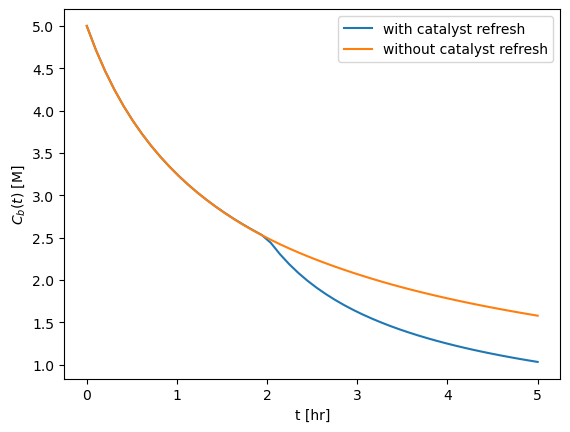

In [4]:
# we define a piecewise function to model the catalyst refresh
def dCb_dt_refresh(t: float, Cb: float, refresh: bool = True) -> float:
    if t > 2.0 and refresh is True:
        k_b = k / (1 + k_d_actual * (t - 2.0))
    else:
        k_b = k / (1 + k_d_actual * t)

    return -k_b * Cb


# set longer time span
t_span = [0, 5]
t_eval = np.linspace(*t_span, 50)

# integrate with refresh
# Note: k_b(t) is non-smooth -> use implicit method
sol_with_refresh = solve_ivp(
    fun=dCb_dt_refresh,
    t_span=t_span,
    y0=[Cb_0],
    t_eval=t_eval,
    args=(True,),
    method="Radau",
)

Cb_with_refresh = sol_with_refresh.y[0]

# integrate without refresh
sol_without_refresh = solve_ivp(
    fun=dCb_dt_refresh, t_span=t_span, y0=[Cb_0], t_eval=t_eval, args=(False,)
)

Cb_without_refresh = sol_without_refresh.y[0]

# plot concentrations over time
fig, ax = plt.subplots()
ax.plot(t_eval, Cb_with_refresh, label="with catalyst refresh")
ax.plot(t_eval, Cb_without_refresh, label="without catalyst refresh")
ax.set_xlabel("t [hr]")
ax.set_ylabel(r"$C_b(t)$ [M]")
ax.legend()

We could also do this with two different ODE solves! Both give the same answer.

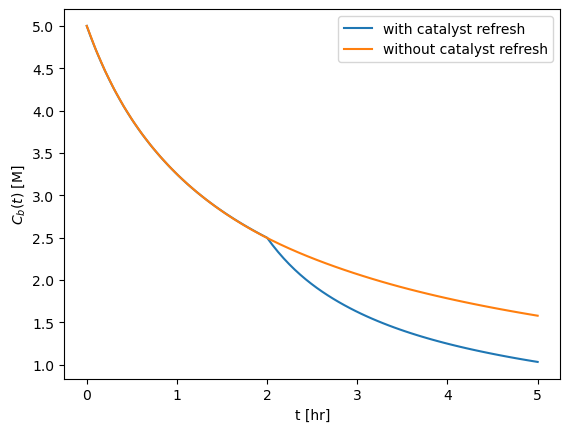

In [5]:
# we define a piecewise function to model the catalyst refresh
def dCb_dt(t: float, Cb: float) -> float:
    k_b = k / (1 + k_d_actual * t)
    return -k_b * Cb


# integrate before refresh
sol_before_refresh = solve_ivp(
    fun=dCb_dt,
    t_span=[0, 2],
    y0=[Cb_0],
    t_eval=np.linspace(0, 2),
)

# Integrate after refresh using the final concentration from the previous step
sol_after_refresh = solve_ivp(
    fun=dCb_dt,
    t_span=[0, 3],
    y0=[sol_before_refresh.y[0, -1]],
    t_eval=np.linspace(0, 3),
)

# Combine the times and concentrations into one solution
# Note that the second time has 2 added to it!
Cb_with_refresh = np.hstack((sol_before_refresh.y, sol_after_refresh.y)).T
t_eval_with_refresh = np.hstack((sol_before_refresh.t, 2 + sol_after_refresh.t))

# Integrate without refresh
sol_without_refresh = solve_ivp(fun=dCb_dt, t_span=t_span, y0=[Cb_0], t_eval=t_eval)
Cb_without_refresh = sol_without_refresh.y[0]

# plot concentrations over time
fig, ax = plt.subplots()
ax.plot(t_eval_with_refresh, Cb_with_refresh, label="with catalyst refresh")
ax.plot(t_eval, Cb_without_refresh, label="without catalyst refresh")
ax.set_xlabel("t [hr]")
ax.set_ylabel(r"$C_b(t)$ [M]")
ax.legend()

# Curve fitting with two species and multiple data (50 pt)

Consider the irreversible reaction:
\begin{align*}
\ce{A + B -> Products}
\end{align*}
with $r=kC_A^nC_B^m$ taking place in an isothermal liquid-phase batch reactor. Measurements of $C_A$ vs $C_B$ are included in the attached file isothermal_liquidphase_batch_data.dat. We wish to determine from the data the rate constant and the order of the reaction with respect to A and B.  We have data from two experiments.

## Load the data from the file into a numpy array and plot the concentration of each species


You can use either the csv library https://docs.python.org/3/library/csv.html or pandas https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html. 

The first column is time in minutes. The second and third column is C_A and C_B for the first experiment (in mol/L). The fourth and fifth column is C_A and C_B for the second experiment. Plot the data for $C_A$ and $C_B$ for each experiment (one experiment per figure).

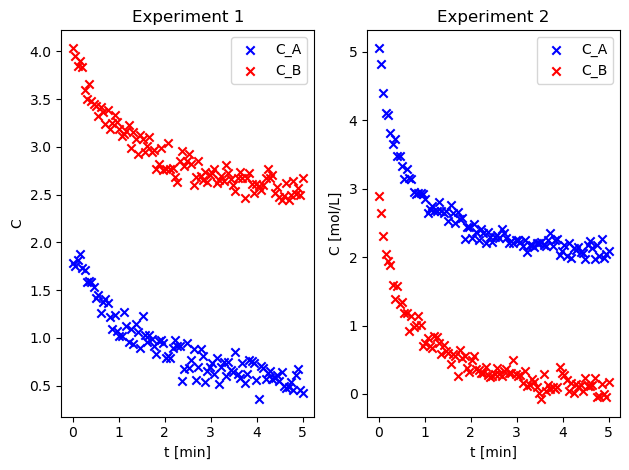

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# read data using regular expression separator
df = pd.read_csv(
    "isothermal_liquidphase_batch.dat",
    sep=r"\s{2,}",
    names=["t", "C_A1", "C_B1", "C_A2", "C_B2"],
    engine="python",
)

# divide data into two data frames with same columns
cols = ["t", "C_A", "C_B"]
df_exp1 = df[["t", "C_A1", "C_B1"]]
df_exp1.columns = cols
df_exp2 = df[["t", "C_A2", "C_B2"]]
df_exp2.columns = cols

# plot data from experiment 1
fig, ax = plt.subplots(1, 2)
# df_exp1.plot(x="t", ax=ax1)
ax[0].scatter(
    x=df_exp1[["t"]].values,
    y=df_exp1[["C_A"]].values,
    marker="x",
    color="b",
    label="C_A",
)
ax[0].scatter(
    x=df_exp1[["t"]].values,
    y=df_exp1[["C_B"]].values,
    marker="x",
    color="r",
    label="C_B",
)
ax[0].set_ylabel("C")
ax[0].set_xlabel("t [min]")
ax[0].set_title("Experiment 1")
ax[0].legend()

# plot data from experiment 2
ax[1].scatter(
    x=df_exp2[["t"]].values,
    y=df_exp2[["C_A"]].values,
    marker="x",
    color="b",
    label="C_A",
)
ax[1].scatter(
    x=df_exp2[["t"]].values,
    y=df_exp2[["C_B"]].values,
    marker="x",
    color="r",
    label="C_B",
)
ax[1].set_ylabel("C [mol/L]")
ax[1].set_xlabel("t [min]")
ax[1].set_title("Experiment 2")
ax[1].legend()

fig.tight_layout()

## Using lmfit, estimate rate parameters $k, n, m$ and initial concentration $C_{A0},C_{B0}$ from the data in the first experiment using a numerical solution for the concentrations of each species (standard mol balance + odeint).  Plot the final fit of the experiment along with the experimental data and calculate the uncertainty in each value

[[Model]]
    Model(integrate_ODE, method='RK45')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 637
    # data points      = 200
    # variables        = 5
    chi-square         = 1.74113659
    reduced chi-square = 0.00892891
    Akaike info crit   = -938.755851
    Bayesian info crit = -922.264264
[[Variables]]
    C_A0:  1.95365491 +/- 0.04451538 (2.28%) (init = 1.785)
    C_B0:  3.96033827 +/- 0.04452883 (1.12%) (init = 4.036)
    k:     3.34116794 +/- 17.5508852 (525.29%) (init = 2)
    n:     3.16366558 +/- 1.63929572 (51.82%) (init = 2)
    m:    -2.18836377 +/- 4.73793623 (216.51%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m)       = -1.000
    C(n, m)       = -0.997
    C(k, n)       = 0.997
    C(C_A0, C_B0) = 0.955
    C(C_B0, m)    = 0.585
    C(C_B0, k)    = -0.583
    C(C_A0, m)    = 0.579
    C(C_A0, k)    = -0.579
    C(C_B0, n)    = -0.550
    C(C_A0, n)    = -0.540


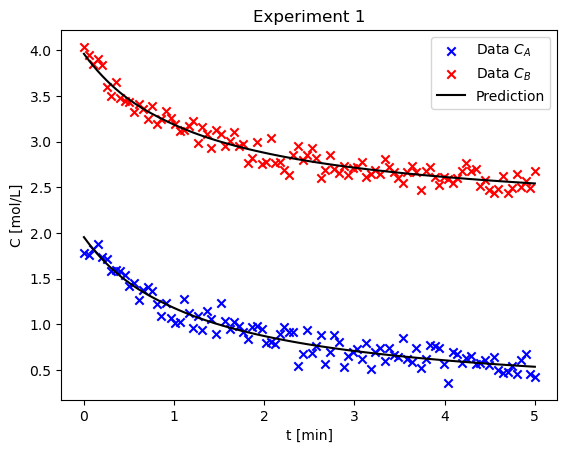

In [7]:
import numpy as np
from lmfit import Model
from scipy.integrate import odeint, solve_ivp


# define ODe for ivp
def reaction_ODE_ivp(t, C, k, n, m):
    C_A, C_B = C
    r = k * (C_A**n) * (C_B**m)
    dC_A_dt = -r
    dC_B_dt = -r
    return np.array([dC_A_dt, dC_B_dt])


# integrate ODE using ivp
def integrate_ODE(t, C_A0, C_B0, k, n, m, method):
    sol = solve_ivp(
        reaction_ODE_ivp,
        t_span=(0, t[-1]),
        t_eval=t,
        y0=np.array([C_A0, C_B0]),
        args=(k, n, m),
        method=method,
    )
    C = sol.y.T
    return C


# define model and fit to data
def fit_model_to_data(t, C_A, C_B, integration_method="RK45"):

    data = np.concatenate([C_A, C_B], axis=1)
    gmodel = Model(
        integrate_ODE,
        independent_vars=["t"],
        param_names=["C_A0", "C_B0", "k", "n", "m"],
        method=integration_method,
    )

    params = gmodel.make_params(C_A0=C_A[0, 0], C_B0=C_B[0, 0], k=2.0, n=2.0, m=2.0)
    result = gmodel.fit(data=data, params=params, t=t)

    return result


# plot data and predictions
def plot_result(result, t, C_A, C_B, ax, title):
    prediction = result.eval(t=t)
    # plot data from experiment
    ax.scatter(t, C_A, label="Data $C_A$", marker="x", color="b")
    ax.scatter(t, C_B, label="Data $C_B$", marker="x", color="r")
    # plot predictions
    ax.plot(t, prediction[:, 0], label="Prediction", color="k")
    ax.plot(t, prediction[:, 1], color="k")
    ax.set_ylabel("C [mol/L]")
    ax.set_xlabel("t [min]")
    ax.set_title(title)
    ax.legend()


# get data as numpy arrays
t = df["t"].values
C_A1 = df["C_A1"].values.reshape(-1, 1)
C_B1 = df["C_B1"].values.reshape(-1, 1)

result1 = fit_model_to_data(t, C_A1, C_B1)
t_eval = t

# plot data from experiment 1
fig, ax = plt.subplots()
plot_result(result1, t_eval, C_A1, C_B1, ax, "Experiment 1")

# print model info
print(result1.fit_report())

## Consider the second experiment, estimate the parameters using only this data. Comment on how the values and confidence intervals are different than the first case

[[Model]]
    Model(integrate_ODE, method='RK45')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 194
    # data points      = 200
    # variables        = 5
    chi-square         = 1.68848917
    reduced chi-square = 0.00865892
    Akaike info crit   = -944.896644
    Bayesian info crit = -928.405057
[[Variables]]
    C_A0:  5.02590997 +/- 0.05648779 (1.12%) (init = 5.059)
    C_B0:  3.01505135 +/- 0.05636404 (1.87%) (init = 2.888)
    k:     0.03315834 +/- 0.01859465 (56.08%) (init = 2)
    n:     2.98279030 +/- 0.48681562 (16.32%) (init = 2)
    m:     0.69365691 +/- 0.14775397 (21.30%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, n)       = -1.000
    C(n, m)       = -0.979
    C(k, m)       = 0.979
    C(C_A0, C_B0) = 0.973
    C(C_A0, n)    = 0.440
    C(C_A0, k)    = -0.430
    C(C_B0, n)    = 0.419
    C(C_B0, k)    = -0.409
    C(C_A0, m)    = -0.354
    C(C_B0, m)    = -0.324


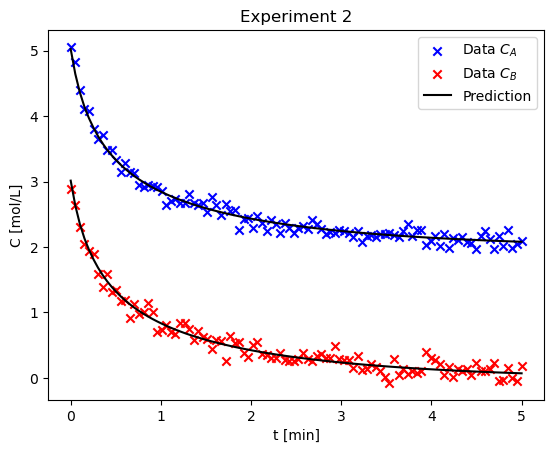

In [8]:
# get data as numpy arrays
t = df["t"].values
C_A2 = df["C_A2"].values.reshape(-1, 1)
C_B2 = df["C_B2"].values.reshape(-1, 1)

result2 = fit_model_to_data(t, C_A2, C_B2, integration_method="RK45")

# plot data from experiment 2
fig, ax = plt.subplots()
plot_result(result2, t_eval, C_A2, C_B2, ax, "Experiment 2")

# print model info
print(result2.fit_report())

## Estimate the parameters using both experiments simultaneously. Are the confidence intervals better? Comment on why or why not.

[[Model]]
    Model(integrate_ODE_both, method='['RK45', 'RK45']')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 175
    # data points      = 400
    # variables        = 7
    chi-square         = 3.46646955
    reduced chi-square = 0.00882053
    Akaike info crit   = -1885.33116
    Bayesian info crit = -1857.39091
[[Variables]]
    C_A0_1:  1.96326655 +/- 0.02921224 (1.49%) (init = 2)
    C_B0_1:  3.96989639 +/- 0.02957282 (0.74%) (init = 4)
    C_A0_2:  4.98419418 +/- 0.04920063 (0.99%) (init = 5)
    C_B0_2:  2.97642327 +/- 0.04963035 (1.67%) (init = 3)
    k:       0.09838765 +/- 0.00342135 (3.48%) (init = 2)
    n:       2.03729582 +/- 0.03103047 (1.52%) (init = 2)
    m:       0.98457622 +/- 0.02522313 (2.56%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_A0_2, C_B0_2) = 0.965
    C(C_A0_1, C_B0_1) = 0.898
    C(k, n)           = -0.893
    C(k, m)           = -0.697
    C(n, m)           = 0.572
    C(C_B0_2, n)      =

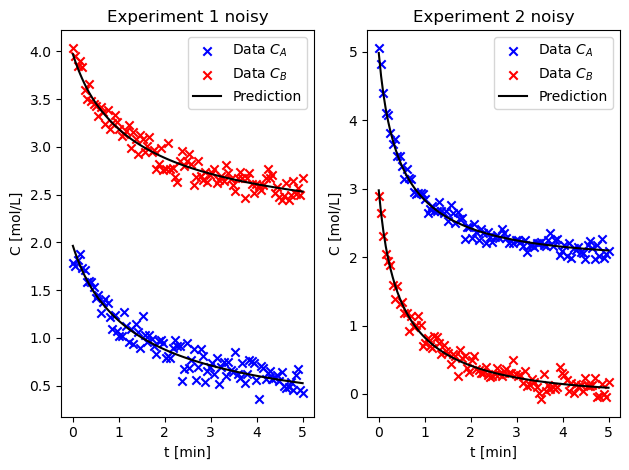

In [9]:
# integrate both ODEs using respective initial conditions
def integrate_ODE_both(t, C_A0_1, C_B0_1, C_A0_2, C_B0_2, k, n, m, method):
    C_1 = solve_ivp(
        reaction_ODE_ivp,
        t_span=(0, t[-1]),
        t_eval=t,
        y0=np.array([C_A0_1, C_B0_1]),
        args=(k, n, m),
        method=method[0],
    ).y.T
    C_2 = solve_ivp(
        reaction_ODE_ivp,
        t_span=(0, t[-1]),
        t_eval=t,
        y0=np.array([C_A0_2, C_B0_2]),
        args=(k, n, m),
        method=method[1],
    ).y.T

    return np.concatenate([C_1, C_2], axis=1)


# define and fit model
def fit_model_to_data_both(
    t, C_A_1, C_B_1, C_A_2, C_B_2, integration_method=["RK45", "RK45"]
):
    # define data set
    data = np.concatenate([C_A_1, C_B_1, C_A_2, C_B_2], axis=1)

    # define model
    gmodel = Model(
        integrate_ODE_both,
        independent_vars=["t"],
        param_names=["C_A0_1", "C_B0_1", "C_A0_2", "C_B0_2", "k", "n", "m"],
        method=integration_method,
    )

    params = gmodel.make_params(
        # initial guesses - very sensitive
        C_A0_1=2,
        C_B0_1=4,
        C_A0_2=5,
        C_B0_2=3,
        k=2,
        n=2,
        m=2,
        method=integration_method,
    )

    result = gmodel.fit(data=data, params=params, t=t)

    return result


# plot predictions and data
def plot_results_both(results_both, t, C_A1, C_B1, C_A2, C_B2, ax, title):
    prediction = result_both.eval(t=t)
    ax[0].scatter(t, C_A1, label="Data $C_A$", marker="x", color="b")
    ax[0].scatter(t, C_B1, label="Data $C_B$", marker="x", color="r")
    ax[0].plot(t, prediction[:, 0], label="Prediction", color="k")
    ax[0].plot(t, prediction[:, 1], color="k")
    ax[0].legend()
    ax[0].set_ylabel("C [mol/L]")
    ax[0].set_xlabel("t [min]")
    ax[0].set_title("Experiment 1 " + title)

    ax[1].scatter(t, C_A2, label="Data $C_A$", marker="x", color="b")
    ax[1].scatter(t, C_B2, label="Data $C_B$", marker="x", color="r")
    ax[1].plot(t, prediction[:, 2], label="Prediction", color="k")
    ax[1].plot(t, prediction[:, 3], color="k")
    ax[1].legend()
    ax[1].set_ylabel("C [mol/L]")
    ax[1].set_xlabel("t [min]")
    ax[1].set_title("Experiment 2 " + title)


# fit model
result_both = fit_model_to_data_both(
    t, C_A1, C_B1, C_A2, C_B2, integration_method=["RK45", "RK45"]
)

# plot data from both experiments
fig, ax = plt.subplots(1, 2)
plot_results_both(result_both, t, C_A1, C_B1, C_A2, C_B2, ax, "noisy")
fig.tight_layout()

# print model info
print(result_both.fit_report())

## Using the noisy data in isothermal_liquidphase_batch_errorfree.dat, repeat the fit using all of the data. Do the results agree with your initial trials?

[[Model]]
    Model(integrate_ODE_both, method='['RK45', 'RK45']')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 232
    # data points      = 400
    # variables        = 7
    chi-square         = 3.0180e-04
    reduced chi-square = 7.6793e-07
    Akaike info crit   = -5624.88794
    Bayesian info crit = -5596.94769
[[Variables]]
    C_A0_1:  2.00087770 +/- 2.7655e-04 (0.01%) (init = 2)
    C_B0_1:  4.00093600 +/- 2.7998e-04 (0.01%) (init = 4)
    C_A0_2:  5.00230806 +/- 4.5646e-04 (0.01%) (init = 5)
    C_B0_2:  3.00237995 +/- 4.6023e-04 (0.02%) (init = 3)
    k:       0.10032598 +/- 3.2176e-05 (0.03%) (init = 2)
    n:       1.99989910 +/- 2.8353e-04 (0.01%) (init = 2)
    m:       1.00227339 +/- 2.3421e-04 (0.02%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_A0_2, C_B0_2) = 0.964
    C(C_A0_1, C_B0_1) = 0.901
    C(k, n)           = -0.890
    C(k, m)           = -0.704
    C(n, m)           = 0.571
    C(C_B0_2, n)      =

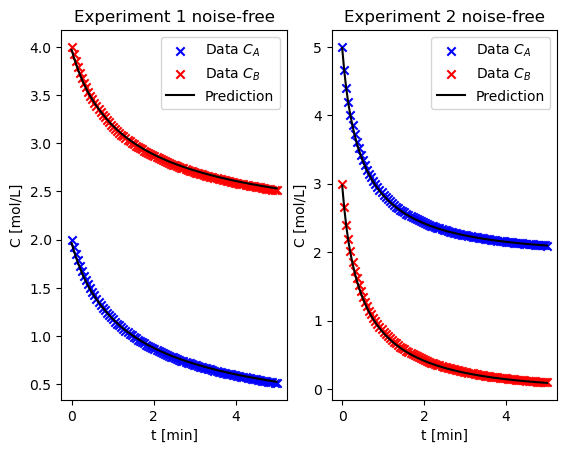

In [10]:
# load noise-free data
df_ef = pd.read_csv(
    "isothermal_liquidphase_batch_errorfree.dat",
    sep=r"\s{2,}",
    names=["t", "C_A1", "C_B1", "C_A2", "C_B2"],
    engine="python",
)

# divide data into two data frames with same columns
cols = ["t", "C_A", "C_B"]
df_exp1_ef = df_ef[["t", "C_A1", "C_B1"]]
df_exp1_ef.columns = cols
df_exp2_ef = df_ef[["t", "C_A2", "C_B2"]]
df_exp2_ef.columns = cols

t_ef = df_ef["t"].values
C_A1_ef = df_ef["C_A1"].values.reshape(-1, 1)
C_B1_ef = df_ef["C_B1"].values.reshape(-1, 1)
C_A2_ef = df_ef["C_A2"].values.reshape(-1, 1)
C_B2_ef = df_ef["C_B2"].values.reshape(-1, 1)

# fit model to data
result_both_ef = fit_model_to_data_both(
    t_ef, C_A1_ef, C_B1_ef, C_A2_ef, C_B2_ef, integration_method=["RK45", "RK45"]
)

# plot data from both experiments
fig_ef, ax_ef = plt.subplots(1, 2)
plot_results_both(
    result_both_ef, t_ef, C_A1_ef, C_B1_ef, C_A2_ef, C_B2_ef, ax_ef, "noise-free"
)
fig.tight_layout()
# print model info
print(result_both_ef.fit_report())

## Based on these results, to determine the order of the rate expression with respect to two different species, how should you choose the initial conditions of the two species?

The parameters should be chosen according to the optimal solutions computed using the full data set.